In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import numpy as np


import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import losses

2022-11-03 19:59:43.349431: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-03 19:59:43.991634: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-03 19:59:43.991691: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-03 19:59:44.094161: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-03 19:59:45.219347: W tensorflow/stream_executor/platform/de

In [2]:
#hmf = pd.read_csv('/home/jazhiel/ML_Notebooks/Datasets/HMF_fit.csv')
#hmf = hmf.drop(['Unnamed: 0'], axis=1)
#dataset_1 = hmf.copy()
#dataset_1


hmf_new = pd.read_csv('HMF_theor.csv')
hmf_new = hmf_new.drop(['Unnamed: 0'], axis=1)

dataset = hmf_new.copy()


x = dataset['log_10(mvir)'].values
y = dataset['n(>M)'].values



In [3]:
dataset

,log_10(mvir),n(>M)
0,1.000000e+10,2.543783e-01
1,1.122018e+10,2.298566e-01
2,1.258925e+10,2.077056e-01
3,1.412538e+10,1.876949e-01
4,1.584893e+10,1.696162e-01
...,...,...
95,5.623413e+14,1.997294e-06
96,6.309573e+14,1.556080e-06
97,7.079458e+14,1.199768e-06
98,7.943282e+14,9.146886e-07


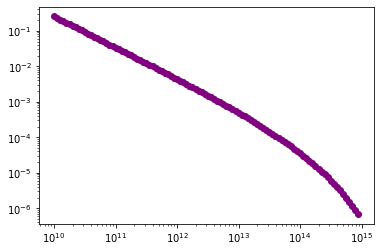

In [4]:
plt.yscale('log')
plt.xscale('log')

plt.scatter(hmf_new['log_10(mvir)'], hmf_new['n(>M)'], c = 'purple')

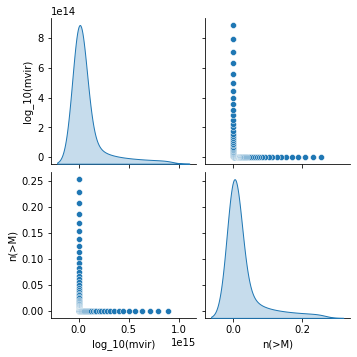

In [5]:
sns.pairplot(dataset, diag_kind="kde")

# plt.savefig("DistHD.png")



In [6]:
randomize = np.random.permutation(len(dataset.values))
data = dataset.values[randomize]

# Define a size for your train set 
split = 0.8
ntrain = int(split * len(data))
indx = [ntrain]
train_set, test_set = np.split(data, indx)

split = 0.5
ntrain = int(split * len(test_set))
indx = [ntrain]
validation_set, test_test = np.split(test_set, indx)

In [7]:
X_train = train_set[:, :-1]
y_train = train_set[:, -1]

X_val = validation_set[:, :-1]
y_val = validation_set[:, -1]

X_test = test_set[:, :-1]
y_test = test_set[:, -1]

In [14]:
print(X_test.shape)
print(y_test.shape)
max(X_train), min(X_train), max(y_train), min(y_train)

(20, 1)
(20,)


(array([4.63996051]),
 array([-0.42999829]),
 0.2543783303196589,
 6.889011444267326e-07)

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

xscaler = StandardScaler()
yscaler = StandardScaler()
#xscaler =   MinMaxScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
xscaler.fit(X_train)
yscaler.fit(y_train.reshape(-1, 1))
# apply transform
X_train = xscaler.transform(X_train)
X_val = xscaler.transform(X_val)
X_test = xscaler.transform(X_test)

y_train = yscaler.transform(y_train.reshape(-1, 1))
y_val = yscaler.transform(y_val.reshape(-1, 1))
y_test = yscaler.transform(y_test.reshape(-1, 1))

In [17]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.0,
                                   patience=50.0,
                                   restore_best_weights=True)]

In [18]:
def ann_model(ninput=1, n_nodes1=100, n_nodes2=100, n_nodes3=100, dropout=0.5):
    model = models.Sequential()
    model.add(layers.Dense(n_nodes1,activation='relu',input_shape=(ninput,)))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(n_nodes2,activation='relu'))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(n_nodes3,activation='relu'))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1, activation='linear'))

    model.compile(optimizer=optimizers.Adam(lr=1e-3),#RMSprop(lr=0.001),
                        loss='mae',
                        metrics=['mae', 'mse'])


#     test1_model.summary()
    return model

In [19]:
# dropout = grid_result.best_params_['dropout']
dropout = 0.3
# n_nodes1 = grid_result.best_params_['n_nodes1']
n_nodes1 = 100
# n_nodes2 = grid_result.best_params_['n_nodes2']
n_nodes2 = 200
# n_nodes3 = grid_result.best_params_['n_nodes3']
n_nodes3 = 150

In [20]:
neural_model = ann_model(n_nodes1=n_nodes1, n_nodes2=n_nodes2, n_nodes3=n_nodes3,
                        dropout=dropout)

estop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                         patience=100, 
                                         restore_best_weights=True)

lrdecay = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                               patience=2)
callbacks = [estop, lrdecay]

neural_model_history = neural_model.fit(X_train,
                                      y_train,
                                      epochs=120,
                                      batch_size=5,
                                      validation_data=(X_val,y_val),
                                      verbose=1)#, #callbacks=callbacks)



2022-11-03 20:03:08.849127: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-03 20:03:08.849758: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-03 20:03:08.849868: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: isidro-pc
2022-11-03 20:03:08.849895: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: isidro-pc
2022-11-03 20:03:08.850115: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2022-11-03 20:03:08.850225: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.85.2
2022-11-03 20:03:08.851470: I tensorflow/core/platform/cpu_feature_guard.cc:193] This Tensor

Epoch 1/120
16/16 [==============================] - 1s 10ms/step - loss: 0.6291 - mae: 0.6291 - mse: 0.9946 - val_loss: 0.5132 - val_mae: 0.5132 - val_mse: 0.9260
Epoch 2/120
16/16 [==============================] - 0s 3ms/step - loss: 0.5443 - mae: 0.5443 - mse: 1.0777 - val_loss: 0.4920 - val_mae: 0.4920 - val_mse: 1.0150
Epoch 3/120
16/16 [==============================] - 0s 2ms/step - loss: 0.5338 - mae: 0.5338 - mse: 1.1730 - val_loss: 0.4829 - val_mae: 0.4829 - val_mse: 1.0060
Epoch 4/120
16/16 [==============================] - 0s 2ms/step - loss: 0.5360 - mae: 0.5360 - mse: 1.0842 - val_loss: 0.4986 - val_mae: 0.4986 - val_mse: 0.9657
Epoch 5/120
16/16 [==============================] - 0s 2ms/step - loss: 0.5202 - mae: 0.5202 - mse: 1.0935 - val_loss: 0.4460 - val_mae: 0.4460 - val_mse: 1.0089
Epoch 6/120
16/16 [==============================] - 0s 2ms/step - loss: 0.5192 - mae: 0.5192 - mse: 1.1864 - val_loss: 0.4072 - val_mae: 0.4072 - val_mse: 1.0008
Epoch 7/120
16/16 [==

16/16 [==============================] - 0s 3ms/step - loss: 0.4654 - mae: 0.4654 - mse: 1.0628 - val_loss: 0.3406 - val_mae: 0.3406 - val_mse: 0.9503
Epoch 52/120
16/16 [==============================] - 0s 3ms/step - loss: 0.4673 - mae: 0.4673 - mse: 1.1067 - val_loss: 0.3349 - val_mae: 0.3349 - val_mse: 0.9416
Epoch 53/120
16/16 [==============================] - 0s 2ms/step - loss: 0.4728 - mae: 0.4728 - mse: 1.0963 - val_loss: 0.3387 - val_mae: 0.3387 - val_mse: 0.9395
Epoch 54/120
16/16 [==============================] - 0s 3ms/step - loss: 0.4683 - mae: 0.4683 - mse: 1.0839 - val_loss: 0.3323 - val_mae: 0.3323 - val_mse: 0.9104
Epoch 55/120
16/16 [==============================] - 0s 2ms/step - loss: 0.4613 - mae: 0.4613 - mse: 1.0697 - val_loss: 0.3233 - val_mae: 0.3233 - val_mse: 0.9088
Epoch 56/120
16/16 [==============================] - 0s 2ms/step - loss: 0.4713 - mae: 0.4713 - mse: 1.0595 - val_loss: 0.3376 - val_mae: 0.3376 - val_mse: 0.9293
Epoch 57/120
16/16 [=========

16/16 [==============================] - 0s 3ms/step - loss: 0.4485 - mae: 0.4485 - mse: 1.0394 - val_loss: 0.3235 - val_mae: 0.3235 - val_mse: 0.9322
Epoch 102/120
16/16 [==============================] - 0s 3ms/step - loss: 0.4547 - mae: 0.4547 - mse: 1.0063 - val_loss: 0.3215 - val_mae: 0.3215 - val_mse: 0.8421
Epoch 103/120
16/16 [==============================] - 0s 3ms/step - loss: 0.4349 - mae: 0.4349 - mse: 0.9910 - val_loss: 0.3079 - val_mae: 0.3079 - val_mse: 0.8818
Epoch 104/120
16/16 [==============================] - 0s 3ms/step - loss: 0.4479 - mae: 0.4479 - mse: 1.0293 - val_loss: 0.3141 - val_mae: 0.3141 - val_mse: 0.9040
Epoch 105/120
16/16 [==============================] - 0s 3ms/step - loss: 0.4440 - mae: 0.4440 - mse: 1.0657 - val_loss: 0.3160 - val_mae: 0.3160 - val_mse: 0.8942
Epoch 106/120
16/16 [==============================] - 0s 3ms/step - loss: 0.4642 - mae: 0.4642 - mse: 0.9253 - val_loss: 0.3188 - val_mae: 0.3188 - val_mse: 0.8109
Epoch 107/120
16/16 [===

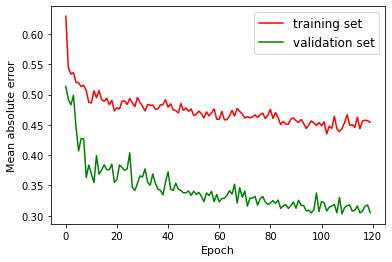

In [21]:
plt.plot(neural_model_history.history['mae'], color='r', )
plt.plot(neural_model_history.history['val_mae'], color='g')


plt.ylabel('Mean absolute error', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)

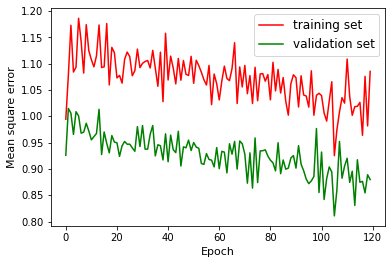

In [22]:
plt.plot(neural_model_history.history['mse'], color='r', )
plt.plot(neural_model_history.history['val_mse'], color='g')


plt.ylabel('Mean square error', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)

In [23]:
ypred2 = neural_model.predict(X_test)
#####
print('Traning and Testing on raw data, all features \n');
#### Model accuracy

# print("Accuracy:", metrics.accuracy_score(y_test, ypred2))

1/1 [==============================] - 0s 67ms/step
Traning and Testing on raw data, all features 



In [33]:
#zor and yor are the original velues for z and [Hz, err]
x_test_or = xscaler.inverse_transform(X_test)
yor = yscaler.inverse_transform(ypred2.reshape(-1,1))

In [34]:
x_test_sort = np.sort(x_test_or.T, axis = 1)
x_test_sort.T

array([[-0.42998356],
       [-0.42996502],
       [-0.42982871],
       [-0.42965245],
       [-0.42954818],
       [-0.42862625],
       [-0.42553652],
       [-0.41576593],
       [-0.38978261],
       [-0.37316867],
       [-0.28716272],
       [-0.17595246],
       [-0.14494724],
       [-0.02732952],
       [ 0.20822198],
       [ 0.70497995],
       [ 0.84347518],
       [ 0.99886939],
       [ 1.58835442],
       [ 4.08860106]])

In [29]:
lcdm = pd.read_csv('lcdm_counts.dat')
#df.drop(['B', 'C'], axis=1)
lcdm = lcdm.drop(['Unnamed: 0'], axis = 1)
lcdm

In [38]:
ypred2_sort = -np.sort(-yor, axis = -1)
ypred2_sort

array([[0.00065454],
       [0.01449963],
       [0.00051468],
       [0.00027638],
       [0.00055696],
       [0.00179343],
       [0.0149184 ],
       [0.00024321],
       [0.00024467],
       [0.00056923],
       [0.00062267],
       [0.01031525],
       [0.00329992],
       [0.01482199],
       [0.00063136],
       [0.00093787],
       [0.01487642],
       [0.01478979],
       [0.01492405],
       [0.01350519]], dtype=float32)

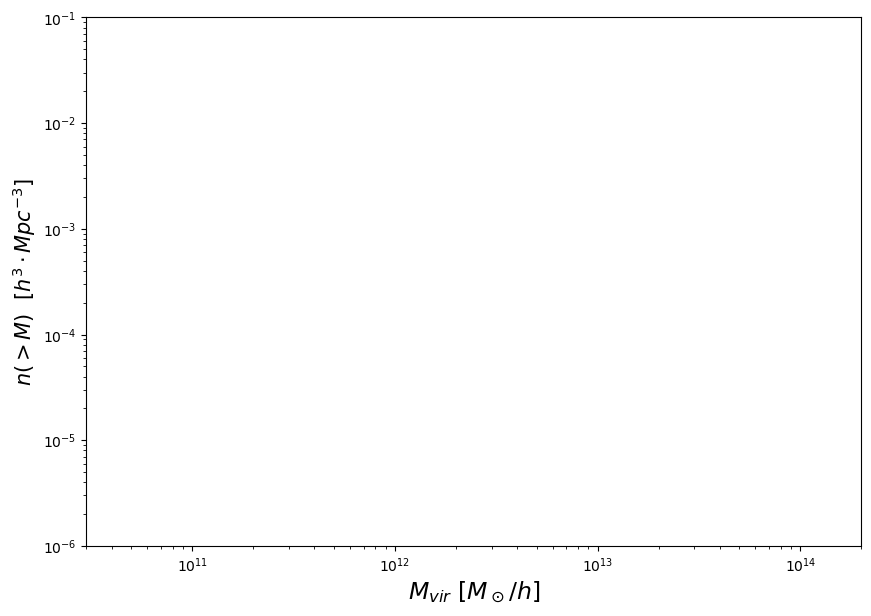

In [42]:


plt.figure(figsize=(10, 7), dpi=100)

plt.yscale('log')
plt.xscale('log')

plt.scatter(10**lcdm['log_10(M200c)'], lcdm['n(>M)'], c = 'purple')
#plt.plot(10**lcdm['log_10(M200c)'], lcdm['n(>M)'], c = 'purple', linestyle = '--', linewidth = 2, label = '$\Lambda$CDM simulation')
plt.plot(10**lcdm['log_10(M200c)'], lcdm['n(>M)'], c = 'purple', linewidth=2, label='$\Lambda$CDM simulation')


#planck = np.loadtxt('/home/jazhiel/ML_Notebooks/YT_ensayo/Rockstar/LCDM/all_plots/mVector_PLANCK-SMT .txt')
#plt.plot(planck[:,0], planck[:,8], 'g', label='Tinker (2008)', linewidth=2)

profile = np.loadtxt('/home/jazhiel/ML_Notebooks/YT_ensayo/Rockstar/LCDM/all_plots/mVector_SIMULATION .txt')
plt.plot(profile[:,0],profile[:,8],'r',label='Press-Schechter (1974) ',linewidth=2)
#plt.legend(loc=0, prop={'size': 14})

plt.scatter(x_test_sort.T,ypred2_sort.T)
plt.plot(x_test_sort.T,ypred2_sort.T)
#plt.scatter(x_test_sort.T,ypred2_sort.T[:,1])
#plt.plot(x_test_sort.T,ypred2_sort.T[:,1])
#plt.scatter(x_test_sort.T,ypred2_sort.T[:,2])
#plt.plot(x_test_sort.T,ypred2_sort.T[:,2])
#plt.scatter(x_test_sort.T,ypred2_sort.T[:,3])
#plt.plot(x_test_sort.T,ypred2_sort.T[:,3])
#plt.scatter(x_test_sort.T,ypred2_sort.T[:,4])
#plt.plot(x_test_sort.T,ypred2_sort.T[:,4])


plt.xlabel('$M_{vir}$ $[M_\odot/h]$',fontsize=17)
plt.ylabel('$n(>M)$  $[h^3 \cdot Mpc^{-3}]$',fontsize=15)

plt.xlim([3.e10,2.e14])
plt.ylim([1.e-6,1.e-1])
#plt.savefig('/home/jazhiel/Escritorio/Maestria/Machine_Learning/IMG_Tesis/HMF_SFDM_extended.png')
plt.show()

In [401]:
x_test_sort.shape

(1, 20)

In [ ]:
ypred2_sort.shape